In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from skimage.feature import graycomatrix, graycoprops
from skimage import data
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# Localized sandsnap texture generation from NAIP


Hypothesis:  VHR resolution satellite imagery (like NAIP) maybe good enough to see a correlation between image texture features (extracted from GLCMs) and sand grain size distribution


In this notebook, we extract median sand grain sizes (D50) from a single beach in NY, world: Jones Beach. This beach has 52 observations spatially spread out across this beach taken in June 2021, and found in the file `data/sandsnap-jones-beach.csv`. Using the NAIP imagery from this beach, we will try to verify if there is a correlation b/w D50 and some GLCM features.

## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [4]:
sandsnap_df = pd.read_csv('../data/sandsnap-world.csv')
sandsnap_df['date'] =  pd.to_datetime(sandsnap_df['CreationDate'], format='%m/%d/%y',infer_datetime_format=True).dt.date
sandsnap_df

,objectid,GlobalID,City,Sample ID,Coin Reference,Location on Beach,Other,CreationDate,Creator,EditDate,...,blurry_metric,ab_value,pixel_count,reprocess_record,reprocess_all_records,Calculated Grain Size,Analysis Status,x,y,date
0,1,b751cc5c-4da0-4179-8aa9-09a076d39023,Patillas,PR001,quarter,the_swash,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.988747,17.973859,2021-06-11
1,2,7cc3efe2-0597-4311-8727-eafcbd442b7f,Loiza,PR002,dime,the_berm,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.986842,18.458983,2021-06-11
2,4,8548bce2-a7bb-4060-84ab-7977603a9185,Rehoboth DE Delaware State Seashore,DSS_foredune,quarter,the_dune,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.067763,38.665109,2021-06-11
3,5,10e8ac4c-08a7-4389-828f-9178d03eb3e2,Rehoboth DE Delaware State Seashore,Dss_berm/beach,quarter,"the_berm,other",Beach,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.067055,38.665189,2021-06-11
4,6,1bd95bf0-71eb-441a-8e07-fcdbf25f21c6,Rehoboth DE Delaware State Seashore,Dss-swash,quarter,the_swash,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.066829,38.665184,2021-06-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1223,aa73d420-8cc1-4858-8333-5d4bd8142831,Vicksburg,Officelighttestelighttest5,nickel,other,NaN,3/10/23 16:11,NaN,3/10/23 16:13,...,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-90.866163,32.298973,2023-03-10
768,1225,592e3c12-6bc2-4435-8cc0-099cdb1c2c98,Vicksburg,Officelighttestelighttest6,nickel,other,NaN,3/10/23 16:29,NaN,3/10/23 16:31,...,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-90.866163,32.298969,2023-03-10
769,1226,dd0d8b2f-5e70-4c3f-8b10-6db5c8bf4dbc,Fort Pierce,NaN,nickel,the_dune,NaN,3/13/23 17:44,NaN,3/13/23 17:46,...,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-80.285356,27.451504,2023-03-13
770,1227,f00e2e34-4409-45f8-8ea9-5479e6ecf386,Ft Pierce,NaN,nickel,the_berm,NaN,3/13/23 17:49,NaN,3/13/23 17:50,...,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-80.284365,27.452367,2023-03-13


### Summary stats for grain size params

In [5]:
sandsnap_df[['D10 mm','D50 mm','D90 mm','DMEAN mm']].describe()

,D10 mm,D50 mm,D90 mm,DMEAN mm
count,772.000000,772.000000,772.000000,772.000000
mean,0.395186,0.598951,0.973894,0.603489
std,0.187683,0.284553,0.462739,0.286693
min,0.057823,0.087542,0.142285,0.088223
25%,0.275873,0.417769,0.679015,0.421017
50%,0.371070,0.561786,0.913091,0.566154
75%,0.477575,0.724330,1.178915,0.729657
max,2.368181,3.595201,5.848548,3.621643


array([[<AxesSubplot:title={'center':'D10 mm'}>,
        <AxesSubplot:title={'center':'D50 mm'}>],
       [<AxesSubplot:title={'center':'D90 mm'}>,
        <AxesSubplot:title={'center':'DMEAN mm'}>]], dtype=object)

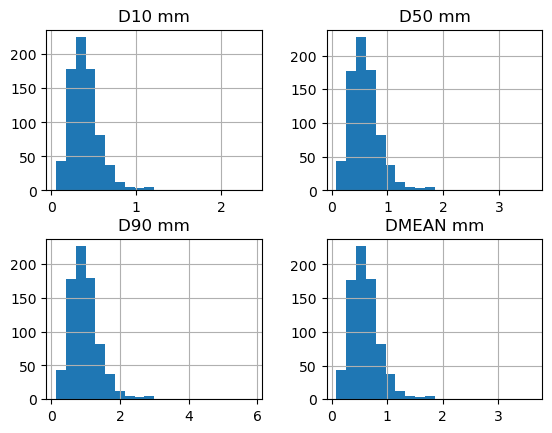

In [6]:
sandsnap_df[['D10 mm','D50 mm','D90 mm','DMEAN mm']].hist(bins=20)

In [5]:
sandsnap_df.dtypes

objectid                                                                                   int64
GlobalID                                                                                  object
City                                                                                      object
Sample ID                                                                                 object
Coin Reference                                                                            object
Location on Beach                                                                         object
Other                                                                                     object
CreationDate                                                                              object
Creator                                                                                   object
EditDate                                                                                  object
Editor                        

### Organize dataframe

In [10]:
world = sandsnap_df[['objectid','Location on Beach','D10 mm','D50 mm','D90 mm','DMEAN mm','Processing Status','date','x','y']]
world = world.rename(columns={'D90 mm':'D90','D50 mm':'D50','D10 mm':'D10','DMEAN mm':'DMEAN','x':'lon', 'y':'lat','Location on Beach':'beach_location'}) #Rename the field

world = world[world['Processing Status'] == 'ok'].drop('Processing Status',axis='columns')
world = world[world['beach_location'].str.contains("the_", na=False)]
world

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184
...,...,...,...,...,...,...,...,...,...
759,1213,the_swash,0.616246,0.932972,1.516392,0.940226,2023-03-03,12.234767,55.537246
760,1214,the_swash,0.541715,0.820135,1.332994,0.826511,2023-03-04,12.157179,55.212933
769,1226,the_dune,0.335783,0.508362,0.826259,0.512315,2023-03-13,-80.285356,27.451504
770,1227,the_berm,0.335866,0.508487,0.826462,0.512441,2023-03-13,-80.284365,27.452367


## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [11]:
side_len_deg = 0.0001 #~11.1m

In [12]:
def bbox(lon, lat, side_len_deg = 0.0001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

## Functions to extract NAIP tiles for each entry

In [13]:
collection = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [14]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

To select the nearest time to a desired time value, we set it to use a nearest neighbour method, 'nearest'. We have to specify the time using a datetime object. [ref](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html)

TODO:
1. Select closest date
2. Check for rainfall near that date - some temporal buffer


In [15]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [16]:
import pyproj

GSD = 10.0 #m/px

def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def S2_data(date, lon, lat, bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],\
            limit_months=5, window_size_px=10, add_to_map=None):
    """
    parameters:
    date: datetime object of the time of observation capture
    lon, lat : coordinates of observation
    bands : list of Sentinel 2 band names
    limit_months : maximum duration before and after date to search for
    buffer : area to crop around (lon,lat) in meters, i.e. a square with side buffer
    
    return type:
    window_size_px : if > 1, will return a numpy array DN values at all pixels within window
            if 1, will return a list of DN values per band at that pixel
    """
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = collection.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 20}},
        limit=10,
    )
    
    items = search.item_collection()
    
    if len(items) == 0:
        print ("No tiles found in ", date_range)
        return None
    
    if len(items) > 0:
        tile = items[0]
    else:
        tile = items
        
#     display(tile)
    
#     print(len(items))
        
    delta_days = abs((tile.datetime.date() - date).days)
    
    if len(items) > 0:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            # print(delta_days)
            if delta_days < delta_min:
                delta_min = delta_days
                tile = item
                
    #Make sure area of overlap is 100%
    if area_of_overlap(tile,aoi) != 1:
        return None
    
    # print("{:} overlapping tile(s) for: {:} | Delta:{:} days"\
    #   .format(len(items),date_range,delta_days))
    
    chosen = stackstac.stack(
        tile,
        assets=bands, 
        # epsg = crs,
        # epsg=3857,
        # chunksize=4096,
        # resolution=100,
    ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    tile = chosen[0] #still has time dimension - removing with this step

    #This is done because the different S2 tiles can have different UTM zones and CRS's
    #that trips up Stackstac -> so choose the epsg as one of them and force them all to be the same
    #OR bypass this process all together and use simple logic to choose the closest date
#     crs = items[0].properties['proj:epsg']
    
#     #convert to xarray with stacstac
#     all_bands = stackstac.stack(
#         items,
#         assets=bands, 
#         epsg = crs,
#         # epsg=3857,
#         # chunksize=4096,
#         # resolution=100,
#     ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    
#     # display(all_bands)
    
#     #Find the one with the closest to date of observation
#     #Doesnt work
#     # return data.sel(time=target_time, method='nearest')
    
#     if all_bands.sizes['time'] > 1: #when the collection (i.e. time dimension) has more than one entry
#         tile = all_bands.sortby(all_bands['eo:cloud_cover'])[0]
#     else:
#         tile = all_bands
    
    # return data
    #Now crop out the AOI:
    x_utm, y_utm = pyproj.Proj(tile.crs)(lon, lat)
    
    #define buffer size in meter to be about 20% larger than required window size
    buffer_m = 100
    window_size_m = window_size_px*GSD
    
    #Make sure buffer isnt too small to correct for skewing of crop box
    buffer_m = window_size_m if window_size_m > buffer_m else buffer_m
    
    aoi = tile.loc[..., y_utm+(buffer_m/2.):y_utm-(buffer_m/2.), x_utm-(buffer_m/2.):x_utm+(buffer_m/2.)].compute()
    
    # display(aoi)
    aoi_np = aoi.to_numpy()
    
    #Now crop to window size:
    img_patch = cropCenter(aoi_np, (aoi_np.shape[0],window_size_px,window_size_px)) #4 for 4 channels
    
    if add_to_map:
        stackstac.add_to_map(aoi[0:3], add_to_map, "", range=[0, 4000])
        marker = ipyleaflet.Marker(location=center, draggable=False)
        add_to_map.add_layer(marker);
    
    if img_patch.shape[1] == 1 and img_patch.shape[2] == 1: #i.e. the number of pixels is one
        return img_patch.reshape(len(img_patch)).tolist()
    return img_patch
    
        

        
    
 

In [17]:
import ipyleaflet
m = ipyleaflet.Map()
m.center = center = world['lat'][376],world['lon'][376]



m.zoom = 12
m.layout.height = "700px"
#stackstac.add_to_map(tile1[4:7], m, "s2", range=[0, 3000])
m

Map(center=[30.03344075, -90.05954755], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

In [18]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=8, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.c36af03f9597451d9c579109e07de400/status


In [19]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.c36af03f9597451d9c579109e07de400/status,


In [20]:
tile1 = S2_data(world['date'][376],world['lon'][376],world['lat'][376], window_size_px=1000, add_to_map=m)

In [17]:
#tile1 = S2_data(world['date'][247],world['lon'][247],world['lat'][247], window_size_px=1000, add_to_map=m)

In [21]:
tile1 = S2_data(world['date'][4],world['lon'][4],world['lat'][4], window_size_px=1)
tile1

[1530.0,
 1860.0,
 2206.0,
 3070.0,
 3020.0,
 3068.0,
 2540.0,
 3383.0,
 3219.0,
 3045.0]

In [22]:
print(world['objectid'][376])

664


In [21]:
tile2 = S2_data(world['date'][50],world['lon'][50],world['lat'][50])
tile2

array([[[1669., 1867., 2015., 2268., 2802., 3110., 2742., 2982., 3114.,
         3080.],
        [1871., 2982., 2708., 2794., 3048., 3040., 3136., 3274., 3202.,
         3192.],
        [2766., 4672., 3340., 3188., 3216., 3266., 3320., 3292., 3166.,
         3084.],
        [2300., 3304., 3186., 3330., 3222., 3326., 3244., 3258., 3230.,
         3242.],
        [2276., 2716., 3120., 3312., 3282., 3314., 3254., 3312., 3226.,
         3158.],
        [2616., 3010., 3010., 3200., 3242., 3308., 3286., 3282., 3154.,
         3128.],
        [2816., 2764., 2284., 2920., 3196., 3288., 3274., 3242., 3136.,
         3182.],
        [2566., 2642., 1954., 2646., 3106., 3220., 3242., 3260., 3264.,
         3352.],
        [2462., 2764., 2590., 2796., 3090., 3144., 3186., 3282., 3322.,
         3350.],
        [2366., 2722., 2968., 2990., 3002., 3102., 3188., 3322., 3392.,
         3330.]],

       [[2188., 2288., 2260., 2670., 3258., 3314., 3104., 3354., 3498.,
         3630.],
        [2236., 293

In [ ]:
# import xrspatial.multispectral as ms
# image = ms.true_color(*(data[2],data[1],data[0])) #bands need to be flipped
# # image = ms.true_color(*data[0:3])
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8, 8))

# ax.set_axis_off()
# image.plot.imshow(ax=ax);

## Update DF with band values

In [23]:
BANDS = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
#drop the first entry, aka outlier with D50 = 3.5mm
# world = world.drop(world.index[0]).reset_index(drop=True)

for band in BANDS:
    world[band] = np.NaN

world['span'] = (world['D90'] - world['D10'])/world['D50']
    
world.head()

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.971084


In [24]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

def get_point_values(df):
    """
    """
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
     
        DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1)
        
        if DNs_point is None:
            print("No tiles for ", sample['objectid'])
            continue
        # print(DNs_point)
        #write to df
        for b, band in enumerate(BANDS):
            # print(b, band)
            df[band].iloc[index] = DNs_point[b]

Wait for 4 workers for upto 10 seconds

In [25]:
%%time
client.wait_for_workers(4, timeout=10)
get_point_values(world)

  0%|          | 0/701 [00:00<?, ?it/s]

No tiles found in  2022-06-05/2022-10-05
No tiles for  660
No tiles for  1056


IndexError: iloc cannot enlarge its target object

In [26]:
world

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,940.0,1282.0,1312.0,1868.0,2137.0,2341.0,2876.0,2379.0,2201.0,1634.0,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,1628.0,2064.0,2404.0,2780.0,3134.0,3283.0,3098.0,3263.0,3248.0,2439.0,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,2752.0,3332.0,3770.0,4232.0,4321.0,4636.0,4676.0,4831.0,5931.0,5866.0,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,2352.0,3138.0,3576.0,4026.0,4051.0,4199.0,4168.0,4329.0,5300.0,5340.0,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,1530.0,1860.0,2206.0,3070.0,3020.0,3068.0,2540.0,3383.0,3219.0,3045.0,0.971084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,1213,the_swash,0.616246,0.932972,1.516392,0.940226,2023-03-03,12.234767,55.537246,1516.0,1794.0,1772.0,2405.0,3223.0,3585.0,3380.0,3943.0,3187.0,2740.0,0.964816
760,1214,the_swash,0.541715,0.820135,1.332994,0.826511,2023-03-04,12.157179,55.212933,4728.0,5396.0,5684.0,6632.0,6258.0,6422.0,7220.0,6560.0,4403.0,3095.0,0.964816
769,1226,the_dune,0.335783,0.508362,0.826259,0.512315,2023-03-13,-80.285356,27.451504,6268.0,6596.0,7144.0,7716.0,7668.0,7823.0,7688.0,7907.0,8571.0,8814.0,0.964816
770,1227,the_berm,0.335866,0.508487,0.826462,0.512441,2023-03-13,-80.284365,27.452367,2770.0,2996.0,3144.0,3502.0,3411.0,3445.0,3338.0,3500.0,4528.0,4342.0,0.964816


## Multiple regression

### Remove all NaNs

In [27]:
df = world[world['B02'].notna()].reset_index(drop=True).copy()
df

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,940.0,1282.0,1312.0,1868.0,2137.0,2341.0,2876.0,2379.0,2201.0,1634.0,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,1628.0,2064.0,2404.0,2780.0,3134.0,3283.0,3098.0,3263.0,3248.0,2439.0,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,2752.0,3332.0,3770.0,4232.0,4321.0,4636.0,4676.0,4831.0,5931.0,5866.0,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,2352.0,3138.0,3576.0,4026.0,4051.0,4199.0,4168.0,4329.0,5300.0,5340.0,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,1530.0,1860.0,2206.0,3070.0,3020.0,3068.0,2540.0,3383.0,3219.0,3045.0,0.971084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,1213,the_swash,0.616246,0.932972,1.516392,0.940226,2023-03-03,12.234767,55.537246,1516.0,1794.0,1772.0,2405.0,3223.0,3585.0,3380.0,3943.0,3187.0,2740.0,0.964816
641,1214,the_swash,0.541715,0.820135,1.332994,0.826511,2023-03-04,12.157179,55.212933,4728.0,5396.0,5684.0,6632.0,6258.0,6422.0,7220.0,6560.0,4403.0,3095.0,0.964816
642,1226,the_dune,0.335783,0.508362,0.826259,0.512315,2023-03-13,-80.285356,27.451504,6268.0,6596.0,7144.0,7716.0,7668.0,7823.0,7688.0,7907.0,8571.0,8814.0,0.964816
643,1227,the_berm,0.335866,0.508487,0.826462,0.512441,2023-03-13,-80.284365,27.452367,2770.0,2996.0,3144.0,3502.0,3411.0,3445.0,3338.0,3500.0,4528.0,4342.0,0.964816


In [28]:
df.isna().sum()

objectid          0
beach_location    0
D10               0
D50               0
D90               0
DMEAN             0
date              0
lon               0
lat               0
B02               0
B03               0
B04               0
B05               0
B06               0
B07               0
B08               0
B8A               0
B11               0
B12               0
span              0
dtype: int64

## Convert Band values to absolute reflectance

For Sentinel-2 optical data (L2A), the relation between DN and REFLECTANCE (default unit) is: DN = 10000 * REFLECTANCE [Source](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/)

Therefore divide by 10000. to get the reflectance value

In [29]:
df[BANDS] = df[BANDS]/(10000.)
df

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,0.0940,0.1282,0.1312,0.1868,0.2137,0.2341,0.2876,0.2379,0.2201,0.1634,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,0.1628,0.2064,0.2404,0.2780,0.3134,0.3283,0.3098,0.3263,0.3248,0.2439,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,0.2752,0.3332,0.3770,0.4232,0.4321,0.4636,0.4676,0.4831,0.5931,0.5866,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,0.2352,0.3138,0.3576,0.4026,0.4051,0.4199,0.4168,0.4329,0.5300,0.5340,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,0.1530,0.1860,0.2206,0.3070,0.3020,0.3068,0.2540,0.3383,0.3219,0.3045,0.971084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,1213,the_swash,0.616246,0.932972,1.516392,0.940226,2023-03-03,12.234767,55.537246,0.1516,0.1794,0.1772,0.2405,0.3223,0.3585,0.3380,0.3943,0.3187,0.2740,0.964816
641,1214,the_swash,0.541715,0.820135,1.332994,0.826511,2023-03-04,12.157179,55.212933,0.4728,0.5396,0.5684,0.6632,0.6258,0.6422,0.7220,0.6560,0.4403,0.3095,0.964816
642,1226,the_dune,0.335783,0.508362,0.826259,0.512315,2023-03-13,-80.285356,27.451504,0.6268,0.6596,0.7144,0.7716,0.7668,0.7823,0.7688,0.7907,0.8571,0.8814,0.964816
643,1227,the_berm,0.335866,0.508487,0.826462,0.512441,2023-03-13,-80.284365,27.452367,0.2770,0.2996,0.3144,0.3502,0.3411,0.3445,0.3338,0.3500,0.4528,0.4342,0.964816


## Find outliers


<AxesSubplot:xlabel='objectid', ylabel='D50'>

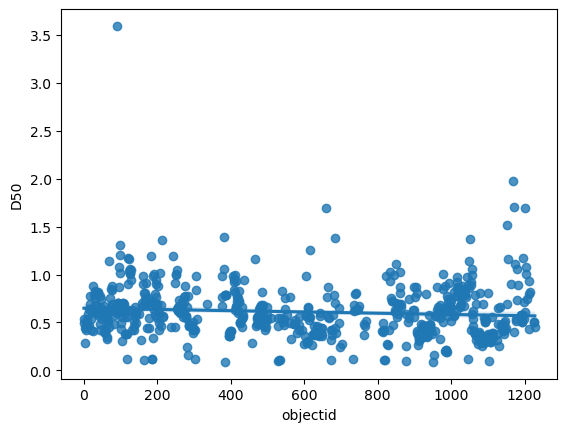

In [30]:
sns.regplot(x='objectid', y='D50', data=df)

In [31]:
df[df.D50 > 2.5]

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
70,92,the_dune,2.368181,3.595201,5.848548,3.621643,2021-06-11,-73.556896,40.580327,0.0853,0.1013,0.0788,0.0789,0.0267,0.0359,0.0404,0.0356,0.0359,0.0324,0.968059


We know from a qualitative inspection of this observation that it had a bunch of shells in it, in an otherwise relatively homogenous grain distribution. 
Also there were many data points nearby which all had much lower D50. Hence, remove

In [32]:
df = df[df.D50 < 2.5].reset_index(drop=True)
df

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,0.0940,0.1282,0.1312,0.1868,0.2137,0.2341,0.2876,0.2379,0.2201,0.1634,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,0.1628,0.2064,0.2404,0.2780,0.3134,0.3283,0.3098,0.3263,0.3248,0.2439,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,0.2752,0.3332,0.3770,0.4232,0.4321,0.4636,0.4676,0.4831,0.5931,0.5866,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,0.2352,0.3138,0.3576,0.4026,0.4051,0.4199,0.4168,0.4329,0.5300,0.5340,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,0.1530,0.1860,0.2206,0.3070,0.3020,0.3068,0.2540,0.3383,0.3219,0.3045,0.971084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,1213,the_swash,0.616246,0.932972,1.516392,0.940226,2023-03-03,12.234767,55.537246,0.1516,0.1794,0.1772,0.2405,0.3223,0.3585,0.3380,0.3943,0.3187,0.2740,0.964816
640,1214,the_swash,0.541715,0.820135,1.332994,0.826511,2023-03-04,12.157179,55.212933,0.4728,0.5396,0.5684,0.6632,0.6258,0.6422,0.7220,0.6560,0.4403,0.3095,0.964816
641,1226,the_dune,0.335783,0.508362,0.826259,0.512315,2023-03-13,-80.285356,27.451504,0.6268,0.6596,0.7144,0.7716,0.7668,0.7823,0.7688,0.7907,0.8571,0.8814,0.964816
642,1227,the_berm,0.335866,0.508487,0.826462,0.512441,2023-03-13,-80.284365,27.452367,0.2770,0.2996,0.3144,0.3502,0.3411,0.3445,0.3338,0.3500,0.4528,0.4342,0.964816


## Save file to disk

In [33]:
df.to_csv('../data/sandsnap-world-s2-reflectance.csv')

## Regress D50/D90/D10

In [34]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.740
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0685
Time:                        04:00:37   Log-Likelihood:                -18.523
No. Observations:                 644   AIC:                             59.05
Df Residuals:                     633   BIC:                             108.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5398      0.032     16.727      0.000       0.476       0.603
B02           -1.4457      0.547     -2.643      0.008      -2.520      -0.372
B03            1.7375      0.939      1.851      0.065      -0.106       3.581
B04           -0.3720      0.674     -0.552      0.581      -1.696       0.952
B05            0.4457      0.563      0.791      0.429      -0.661       1.552
B06           -1.3796      0.990     -1.394      0.164      -3.324       0.564
B07            0.8462      0.999      0.847      0.397      -1.115       2.807
B08           -0.3385      0.360     -0.941      0.347      -1.045       0.368
B8A            0.4046      0.835      0.485      0.628      -1.235       2.044
B11            0.0206      0.548      0.038      0.970      -1.056       1.097
B12            0.0966      0.401      0.241      0.810      -0.691       0.884
==============================================================================
Omnibus:                      107.449   Durbin-Watson:                   1.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.112
Skew:                           0.925   Prob(JB):                     4.82e-50
Kurtosis:                       5.245   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D90 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D90   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.740
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0685
Time:                        04:01:06   Log-Likelihood:                -331.66
No. Observations:                 644   AIC:                             685.3
Df Residuals:                     633   BIC:                             734.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8785      0.052     16.742      0.000       0.775       0.982
B02           -2.3497      0.889     -2.642      0.008      -4.096      -0.603
B03            2.8195      1.526      1.847      0.065      -0.178       5.817
B04           -0.6037      1.096     -0.551      0.582      -2.756       1.549
B05            0.7264      0.916      0.793      0.428      -1.073       2.526
B06           -2.2441      1.610     -1.394      0.164      -5.405       0.917
B07            1.3760      1.624      0.847      0.397      -1.813       4.565
B08           -0.5492      0.585     -0.939      0.348      -1.698       0.600
B8A            0.6556      1.358      0.483      0.629      -2.011       3.322
B11            0.0323      0.891      0.036      0.971      -1.718       1.783
B12            0.1590      0.652      0.244      0.807      -1.121       1.439
==============================================================================
Omnibus:                      107.036   Durbin-Watson:                   1.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.527
Skew:                           0.923   Prob(JB):                     1.07e-49
Kurtosis:                       5.236   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D10 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D10   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.740
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0686
Time:                        04:01:10   Log-Likelihood:                 249.43
No. Observations:                 644   AIC:                            -476.9
Df Residuals:                     633   BIC:                            -427.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3552      0.021     16.688      0.000       0.313       0.397
B02           -0.9558      0.361     -2.649      0.008      -1.664      -0.247
B03            1.1542      0.619      1.864      0.063      -0.062       2.370
B04           -0.2476      0.445     -0.557      0.578      -1.121       0.625
B05            0.2921      0.372      0.786      0.432      -0.438       1.022
B06           -0.9093      0.653     -1.392      0.164      -2.192       0.373
B07            0.5582      0.659      0.847      0.397      -0.735       1.852
B08           -0.2248      0.237     -0.947      0.344      -0.691       0.241
B8A            0.2694      0.551      0.489      0.625      -0.812       1.351
B11            0.0151      0.362      0.042      0.967      -0.695       0.725
B12            0.0612      0.264      0.231      0.817      -0.458       0.580
==============================================================================
Omnibus:                      108.515   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.184
Skew:                           0.930   Prob(JB):                     6.30e-51
Kurtosis:                       5.270   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.768
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0967
Time:                        04:01:14   Log-Likelihood:                -25.869
No. Observations:                 644   AIC:                             55.74
Df Residuals:                     642   BIC:                             64.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5665      0.025     22.782      0.000       0.518       0.615
B11            0.1023      0.062      1.664      0.097      -0.018       0.223
==============================================================================
Omnibus:                      120.328   Durbin-Watson:                   1.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.019
Skew:                           0.983   Prob(JB):                     2.12e-62
Kurtosis:                       5.592   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D90   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.729
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0990
Time:                        04:01:14   Log-Likelihood:                -339.03
No. Observations:                 644   AIC:                             682.1
Df Residuals:                     642   BIC:                             691.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9215      0.040     22.790      0.000       0.842       1.001
B11            0.1652      0.100      1.652      0.099      -0.031       0.362
==============================================================================
Omnibus:                      119.863   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.925
Skew:                           0.981   Prob(JB):                     6.04e-62
Kurtosis:                       5.581   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D10   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.867
Date:                Wed, 15 Mar 2023   Prob (F-statistic):             0.0909
Time:                        04:01:14   Log-Likelihood:                 242.14
No. Observations:                 644   AIC:                            -480.3
Df Residuals:                     642   BIC:                            -471.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3733      0.016     22.760      0.000       0.341       0.405
B11            0.0687      0.041      1.693      0.091      -0.011       0.148
==============================================================================
Omnibus:                      121.537   Durbin-Watson:                   1.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              289.452
Skew:                           0.989   Prob(JB):                     1.40e-63
Kurtosis:                       5.622   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

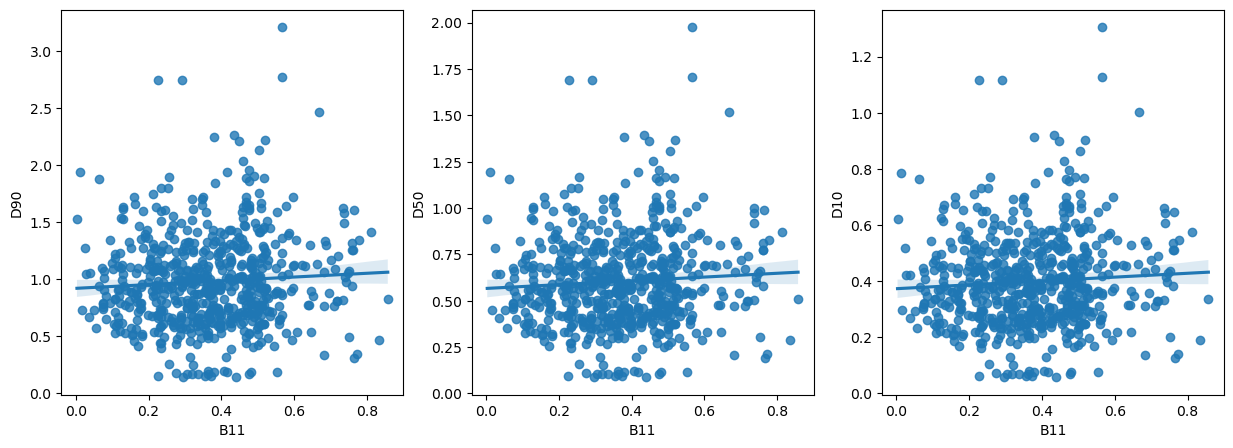

In [37]:
model2 = smf.ols(formula='D50 ~ B11', data=df).fit()
model1 = smf.ols(formula='D90 ~ B11', data=df).fit()
model3 = smf.ols(formula='D10 ~ B11', data=df).fit()
display(model2.summary())
display(model1.summary())
display(model3.summary())

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(15,5))

sns.regplot(x='B11', y='D50', data=df, ax=axs[1])
sns.regplot(x='B11', y='D90', data=df, ax=axs[0])
sns.regplot(x='B11', y='D10', data=df, ax=axs[2])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.165
Date:                Wed, 15 Mar 2023   Prob (F-statistic):              0.281
Time:                        04:01:45   Log-Likelihood:                -26.670
No. Observations:                 644   AIC:                             57.34
Df Residuals:                     642   BIC:                             66.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5781      0.026     21.988      0.000       0.526       0.630
B8A            0.0715      0.066      1.079      0.281      -0.059       0.202
==============================================================================
Omnibus:                      120.490   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.861
Skew:                           0.985   Prob(JB):                     2.29e-62
Kurtosis:                       5.588   Cond. No.                         7.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B8A', ylabel='D50'>

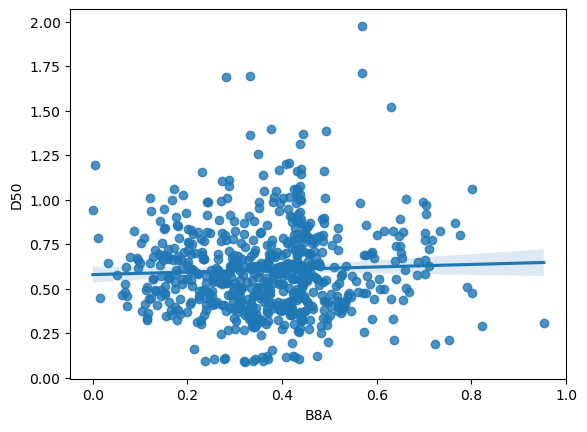

In [38]:
model_hom = smf.ols(formula='D50 ~ B8A', data=df).fit()
display(model_hom.summary())
sns.regplot(x='B8A', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4750
Date:                Wed, 15 Mar 2023   Prob (F-statistic):              0.491
Time:                        04:03:06   Log-Likelihood:                -27.016
No. Observations:                 644   AIC:                             58.03
Df Residuals:                     642   BIC:                             66.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5885      0.025     23.385      0.000       0.539       0.638
B08            0.0432      0.063      0.689      0.491      -0.080       0.166
==============================================================================
Omnibus:                      122.088   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.299
Skew:                           0.994   Prob(JB):                     9.17e-64
Kurtosis:                       5.621   Cond. No.                         7.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B08', ylabel='D50'>

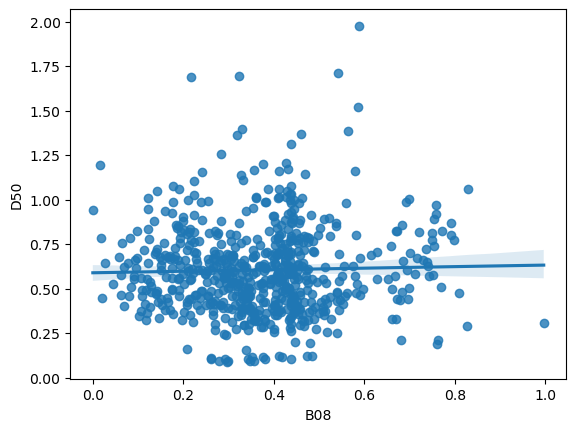

In [41]:
model_con = smf.ols(formula='D50 ~ B08', data=df).fit()
display(model_con.summary())
sns.regplot(x='B08', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1125
Date:                Wed, 15 Mar 2023   Prob (F-statistic):              0.737
Time:                        04:03:15   Log-Likelihood:                -27.198
No. Observations:                 644   AIC:                             58.40
Df Residuals:                     642   BIC:                             67.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6114      0.023     26.279      0.000       0.566       0.657
B02           -0.0270      0.080     -0.335      0.737      -0.185       0.131
==============================================================================
Omnibus:                      124.641   Durbin-Watson:                   1.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.968
Skew:                           1.009   Prob(JB):                     7.29e-66
Kurtosis:                       5.666   Cond. No.                         8.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B02', ylabel='D50'>

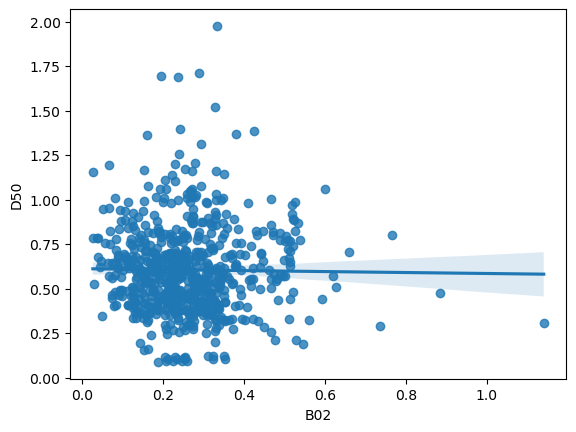

In [42]:
model = smf.ols(formula='D50 ~ B02', data=df).fit()
display(model.summary())
sns.regplot(x='B02', y='D50', data=df)
# plt.scatter(world['correlation'], world['D50'])
# plt.plot(model_corr,linestyle ='dotted')
# plt.xlabel('correlation')
# plt.ylabel('D50')
# plt.show()

# Random Forest Regression

Clearly no linearity can be found at these spatial scale (0.6m). This is likely telling us that the texture features are all but lost at this resolution for detecting particle sizes of this size (<2mm)

In [43]:
df.head()

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,0.0940,0.1282,0.1312,0.1868,0.2137,0.2341,0.2876,0.2379,0.2201,0.1634,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,0.1628,0.2064,0.2404,0.2780,0.3134,0.3283,0.3098,0.3263,0.3248,0.2439,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,0.2752,0.3332,0.3770,0.4232,0.4321,0.4636,0.4676,0.4831,0.5931,0.5866,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,0.2352,0.3138,0.3576,0.4026,0.4051,0.4199,0.4168,0.4329,0.5300,0.5340,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,0.1530,0.1860,0.2206,0.3070,0.3020,0.3068,0.2540,0.3383,0.3219,0.3045,0.971084


In [44]:
y = df['D50']
X = df[BANDS]
display(X)
display(y)
type(y)

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,0.0940,0.1282,0.1312,0.1868,0.2137,0.2341,0.2876,0.2379,0.2201,0.1634
1,0.1628,0.2064,0.2404,0.2780,0.3134,0.3283,0.3098,0.3263,0.3248,0.2439
2,0.2752,0.3332,0.3770,0.4232,0.4321,0.4636,0.4676,0.4831,0.5931,0.5866
3,0.2352,0.3138,0.3576,0.4026,0.4051,0.4199,0.4168,0.4329,0.5300,0.5340
4,0.1530,0.1860,0.2206,0.3070,0.3020,0.3068,0.2540,0.3383,0.3219,0.3045
...,...,...,...,...,...,...,...,...,...,...
639,0.1516,0.1794,0.1772,0.2405,0.3223,0.3585,0.3380,0.3943,0.3187,0.2740
640,0.4728,0.5396,0.5684,0.6632,0.6258,0.6422,0.7220,0.6560,0.4403,0.3095
641,0.6268,0.6596,0.7144,0.7716,0.7668,0.7823,0.7688,0.7907,0.8571,0.8814
642,0.2770,0.2996,0.3144,0.3502,0.3411,0.3445,0.3338,0.3500,0.4528,0.4342


0      0.492118
1      0.533849
2      0.286746
3      0.445790
4      0.460296
         ...   
639    0.932972
640    0.820135
641    0.508362
642    0.508487
643    0.451871
Name: D50, Length: 644, dtype: float64

pandas.core.series.Series

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [52]:
X_test

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
631,0.1554,0.2212,0.1856,0.2453,0.3735,0.4465,0.4868,0.4683,0.3461,0.2714
592,0.1875,0.2332,0.2402,0.2730,0.1939,0.2051,0.1589,0.1802,0.1166,0.1129
599,0.2770,0.4024,0.5304,0.5966,0.5953,0.6066,0.5808,0.5778,0.7104,0.6116
291,0.2580,0.2764,0.2742,0.3203,0.3156,0.3198,0.2780,0.3197,0.3724,0.3561
72,0.2932,0.3464,0.3914,0.4114,0.4103,0.4269,0.4372,0.4385,0.5047,0.5200
...,...,...,...,...,...,...,...,...,...,...
333,0.2300,0.2814,0.3096,0.3324,0.3683,0.3888,0.4156,0.4174,0.3907,0.3098
591,0.3308,0.3754,0.4112,0.4239,0.4281,0.4397,0.4676,0.4403,0.4996,0.4698
326,0.2528,0.3092,0.3442,0.3794,0.4025,0.4063,0.4038,0.4119,0.3526,0.2786
318,0.3056,0.3432,0.3600,0.3879,0.3468,0.3622,0.3808,0.3520,0.2355,0.1928


In [49]:
# Train the model
rf = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [50]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
631,0.1554,0.2212,0.1856,0.2453,0.3735,0.4465,0.4868,0.4683,0.3461,0.2714,0.712443,0.689719
592,0.1875,0.2332,0.2402,0.2730,0.1939,0.2051,0.1589,0.1802,0.1166,0.1129,0.377903,0.566762
599,0.2770,0.4024,0.5304,0.5966,0.5953,0.6066,0.5808,0.5778,0.7104,0.6116,0.473520,1.182985
291,0.2580,0.2764,0.2742,0.3203,0.3156,0.3198,0.2780,0.3197,0.3724,0.3561,0.093606,0.475040
72,0.2932,0.3464,0.3914,0.4114,0.4103,0.4269,0.4372,0.4385,0.5047,0.5200,0.703173,1.051617


In [51]:
import matplotlib.pyplot as plt

# Define x axis
x_axis = X_test.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'D50'

## Tuning hyperparameters

In [53]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 70, 'n_estimators': 1100}

In [54]:
rf = RandomForestRegressor(n_estimators = 1100, max_depth = 70, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=70, n_estimators=1100, random_state=42)

In [55]:
X_test

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
631,0.1554,0.2212,0.1856,0.2453,0.3735,0.4465,0.4868,0.4683,0.3461,0.2714
592,0.1875,0.2332,0.2402,0.2730,0.1939,0.2051,0.1589,0.1802,0.1166,0.1129
599,0.2770,0.4024,0.5304,0.5966,0.5953,0.6066,0.5808,0.5778,0.7104,0.6116
291,0.2580,0.2764,0.2742,0.3203,0.3156,0.3198,0.2780,0.3197,0.3724,0.3561
72,0.2932,0.3464,0.3914,0.4114,0.4103,0.4269,0.4372,0.4385,0.5047,0.5200
...,...,...,...,...,...,...,...,...,...,...
333,0.2300,0.2814,0.3096,0.3324,0.3683,0.3888,0.4156,0.4174,0.3907,0.3098
591,0.3308,0.3754,0.4112,0.4239,0.4281,0.4397,0.4676,0.4403,0.4996,0.4698
326,0.2528,0.3092,0.3442,0.3794,0.4025,0.4063,0.4038,0.4119,0.3526,0.2786
318,0.3056,0.3432,0.3600,0.3879,0.3468,0.3622,0.3808,0.3520,0.2355,0.1928


In [56]:
# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
631,0.1554,0.2212,0.1856,0.2453,0.3735,0.4465,0.4868,0.4683,0.3461,0.2714,0.712443,0.537378
592,0.1875,0.2332,0.2402,0.2730,0.1939,0.2051,0.1589,0.1802,0.1166,0.1129,0.377903,0.647364
599,0.2770,0.4024,0.5304,0.5966,0.5953,0.6066,0.5808,0.5778,0.7104,0.6116,0.473520,1.122288
291,0.2580,0.2764,0.2742,0.3203,0.3156,0.3198,0.2780,0.3197,0.3724,0.3561,0.093606,0.467558
72,0.2932,0.3464,0.3914,0.4114,0.4103,0.4269,0.4372,0.4385,0.5047,0.5200,0.703173,1.063341


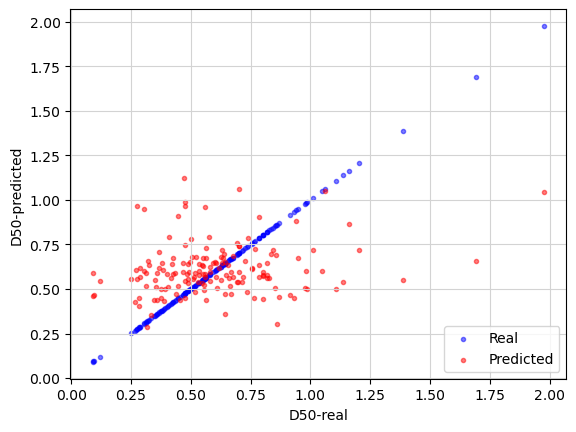

In [57]:
# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

## Error Estimation

In [58]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 0.2
Mean Squared Error: 0.08
R-squared scores: -0.07


## Defining and visualizing variables importance

In [78]:
# Get features list
characteristics = X.columns
# Get the variables importances, sort them, and print the result
importances = list(rf.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: B11                  Importance: 0.12
Variable: B12                  Importance: 0.12
Variable: B04                  Importance: 0.11
Variable: B05                  Importance: 0.11
Variable: B08                  Importance: 0.11
Variable: B02                  Importance: 0.1
Variable: B03                  Importance: 0.1
Variable: B8A                  Importance: 0.09
Variable: B06                  Importance: 0.08
Variable: B07                  Importance: 0.06


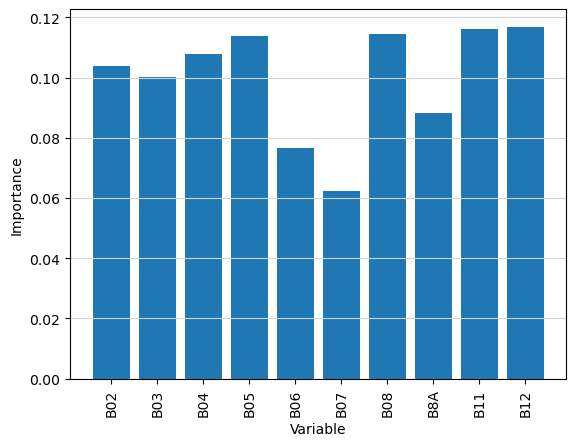

In [79]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()